### Control Digital en Sistemas Embebidos - MSE - PRACTICA 3

In [1]:
!pipenv install slycot
!pipenv install control
!pipenv install matplotlib

"pipenv" no se reconoce como un comando interno o externo,
programa o archivo por lotes ejecutable.
"pipenv" no se reconoce como un comando interno o externo,
programa o archivo por lotes ejecutable.
"pipenv" no se reconoce como un comando interno o externo,
programa o archivo por lotes ejecutable.


In [2]:
import numpy as np
import control as cnt
from scipy.linalg import expm
import matplotlib.pyplot as plt

**1)** Crear una función en Matlab que aplique la función del controlador PID y obtenga la señal de control para una determinada señal de referencia y señal de salida.

In [3]:
def pid_controller(pid_data: dict) -> dict:
    
    data = pid_data.copy()
    
    p = data['kp'] * (data['b'] * data['r'] - data['y'])
    i = data['future_i']
    d = (data['kd'] / (data['kd'] + data['n'] * data['h'])) * (data['past_d'] - data['n'] * (data['y'] - data['past_y']))
    
    data['u'] = p + i + d
    
    data['future_i'] = i + data['ki'] * data['h'] * (data['r'] - data['y'])
    data['past_d'] = d
    data['past_y'] = data['y']
    
    return data

In [4]:
def pid_controller_response(num: np.ndarray, den: np.ndarray, input: np.ndarray, pid_data: dict) -> np.ndarray:
    
    a = np.array(den).flatten()
    b = np.array(num).flatten()
    
    n_inicial = len(a) - 1
    
    y = np.zeros(len(input) + n_inicial)
    r = np.concatenate((np.zeros(n_inicial), input), axis=None)
    u = np.concatenate((np.zeros(n_inicial), input), axis=None)
    
    data = pid_data.copy()
    
    for k in range(n_inicial, len(r)):

      data['y'] = y[k-1]
      data['r'] = r[k]

      data = pid_controller(data)
    
      u[k] = data['u']

      for m in range(0, len(b)):
        y[k] = y[k] + b[m] * u[k-m]
      
      for n in range(1, len(a)):
        y[k] = y[k] - a[n] * y[k-n]
    
      y[k] = y[k] / a[0]
    
    return y[n_inicial-1:]

**2)** Discretizar la planta.

In [16]:
h = 0.01

s = cnt.tf('s')
hs = (0.2*s+1) / (0.1*s*s + 0.4*s +1 )
hz = cnt.c2d(hs, h, 'zoh')
hz


TransferFunction(array([ 0.02009537, -0.01911519]), array([ 1.        , -1.95980926,  0.96078944]), 0.01)

In [6]:
numz, denz = cnt.tfdata(hz)
numz, denz

([[array([ 0.02009537, -0.01911519])]],
 [[array([ 1.        , -1.95980926,  0.96078944])]])

**3)** Obtener la respuesta al escalón en tiempo continuo y discreto.

In [7]:
t = np.linspace(h, h * 1000, 1000)
u = np.concatenate((np.zeros(int(len(t) / 2)), np.ones(int(len(t) / 2))), axis=None)

In [8]:
t_hz_1, y_hz_1 = cnt.forced_response(hz, t, u)

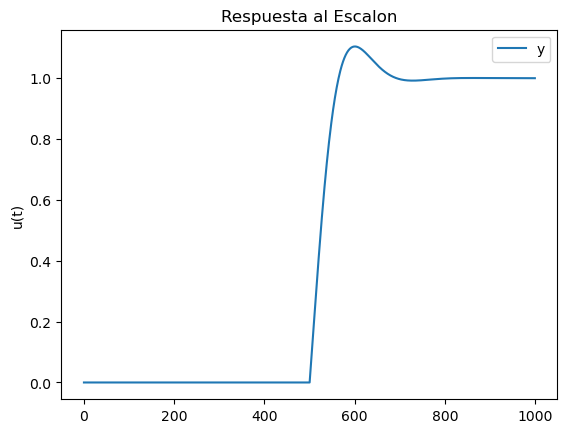

In [9]:
p_1 = plt.plot(y_hz_1)
plt.ylabel('u(t)')
plt.title('Respuesta al Escalon')
plt.legend('y(t)');

**4)** Aplicar un control PID utilizando la función creada anteriormente. Obtener señal de control y graficarla.

In [10]:
t = np.linspace(h, h * 1000, 1000)
r = np.concatenate((np.zeros(int(len(t) / 2)), np.ones(int(len(t) / 2))), axis=None)

In [11]:
pid_data = dict()

pid_data['kp'] = 2.6

# Ki = Kp / Ti
pid_data['ki'] = 0.08 / h

# Kd = Kp * Td
pid_data['kd'] = 10 * h

pid_data['h'] = h
pid_data['n'] = 20
pid_data['b'] = 1

pid_data['future_i'] = 0
pid_data['past_d'] = 0
pid_data['past_y'] = 0

In [12]:
y_hz_pid = pid_controller_response(numz, denz, r, pid_data)

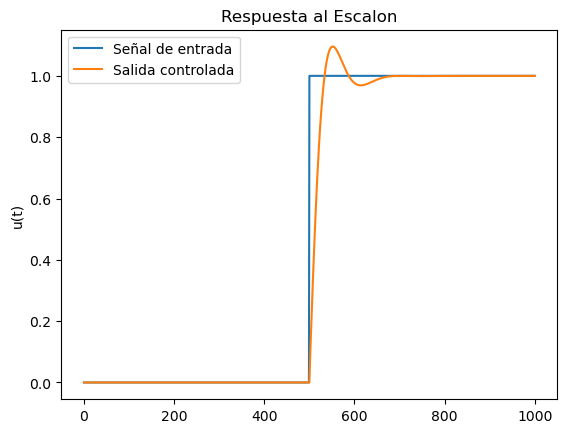

In [13]:
p_1 = plt.plot(r)
p_2 = plt.plot(y_hz_pid)
plt.ylabel('u(t)')
plt.title('Respuesta al Escalon')
plt.legend((p_1[0], p_2[0]), ('Señal de entrada', 'Salida controlada'));

**5)** Comparar la respuesta al escalón del punto 3 con la respuesta obtenida aplicando el control PID anterior.

In [14]:
t_hz_open, y_hz_open = cnt.forced_response(hz, t, r)

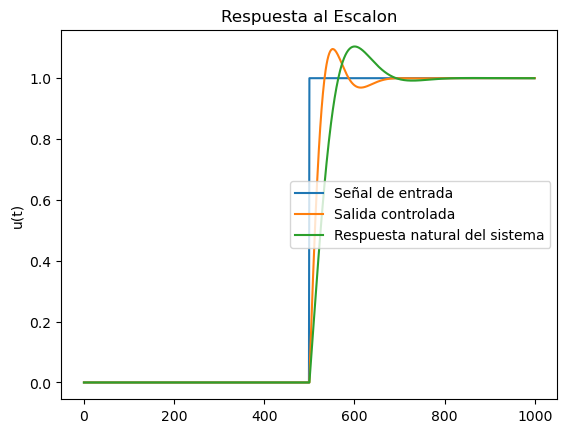

In [15]:
p_1 = plt.plot(r)
p_2 = plt.plot(y_hz_pid)
p_3 = plt.plot(y_hz_open)
plt.ylabel('u(t)')
plt.title('Respuesta al Escalon')
plt.legend((p_1[0], p_2[0], p_3[0]), ('Señal de entrada', 'Salida controlada', 'Respuesta natural del sistema'));